In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import datetime
import time

import random

import math
import pandas as pd

In [22]:
import os
print(os.getcwd())
from distutils.core import setup
from Cython.Build import cythonize
from numba import jit, njit

%load_ext Cython

F:\Portfolio\UFL
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [31]:
#@njit
def check_int_sol(sol_array):
    tol = 1e-6
    for sol in sol_array:
        if abs(sol - int(sol)) > tol:
            return False
    return True

In [3]:
os.chdir(r'F:/Portfolio/UFL/')

In [15]:
data_path = r"data/M/O/"
filename = 'MO1'

In [16]:
with open(data_path+filename) as file:
    sizes = np.fromstring(file.readline(), dtype=int, sep=" ")
    m, n = sizes[0], sizes[1] # m = no. of customers; n = no. of facilites
    print(m, n)
    capacity = np.empty(n)
    opening_cost = np.empty(n)
    demand = np.empty(m)
    serving_cost = np.empty([m, n])
    for i in range(n):
        section_1_line = np.fromstring(file.readline(), dtype=float, sep=" ")
        capacity[i], opening_cost[i] = section_1_line[0], section_1_line[1]
    for i in range(m):
        demand[i] = np.fromstring(file.readline(), dtype=float, sep=" ")
        serving_cost[i, :] = np.fromstring(file.readline(), dtype=float, sep=" ")

100 100


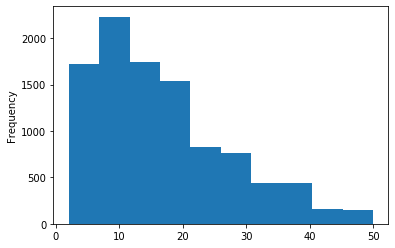

In [17]:
dff = pd.Series(serving_cost.flatten())
dff.plot.hist()

In [18]:
n_client = len(demand)
n_facility = len(opening_cost)
print(n_client, "Demand Locations or Clients")

print(n_facility, "Facilities")

100 Demand Locations or Clients
100 Facilities


In [19]:
df = pd.DataFrame(serving_cost).head(10)
df = df.rename_axis("Facilities", axis="columns")
df = df.rename_axis("Clients", axis="rows")
df.head(5)

Facilities,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Clients,,,,,,,,,,,,,,,,,,,,,
0,2.37627,5.31695,5.57118,5.83591,9.15027,5.82114,5.77960,5.67768,4.49169,6.72159,...,6.46666,2.17409,3.42665,4.39220,7.97902,5.49366,5.04129,8.15626,3.59279,4.40500
1,9.45280,3.21590,7.81713,6.76244,8.37225,4.75309,4.95507,5.71846,4.03081,8.64646,...,6.50485,4.65022,7.14090,4.46423,4.46473,5.88768,7.99023,6.40044,3.12517,7.52048
2,17.18240,5.51389,15.24870,10.05870,5.66571,11.18050,4.92069,19.05850,12.24140,4.41981,...,18.32730,13.46990,4.83425,9.93675,6.29434,10.62850,19.63810,8.94523,19.53320,7.04157
3,8.27847,7.92073,8.12976,7.45249,7.86574,4.25142,3.49568,7.83872,3.50782,9.26896,...,6.16701,8.55182,2.00478,7.41689,4.18369,9.23453,8.91085,2.15172,3.20007,8.19683
4,3.99216,5.89499,9.66227,6.38394,6.88412,6.33420,8.17981,2.32795,7.02377,7.42180,...,7.02252,7.86589,4.46928,2.65191,6.82275,2.42109,4.28059,6.75315,2.41353,9.38202


In [20]:
model = gp.Model('UFL disaggregated')

# Variables
# 2d indices
# x[i,j] = Fraction of client i demand served by facility j

x = model.addVars(n_client, n_facility, obj=serving_cost, vtype=GRB.CONTINUOUS, name='x')
y = model.addVars(n_facility, obj=opening_cost, vtype=GRB.BINARY, name='y')
p = model.addVars(n_client, vtype=GRB.CONTINUOUS, name='p')

model.addConstrs((1 - x.sum(m, '*') == p[m] for m in range(n_client)), name='assignment_cons') #tupledict.sum()
model.addConstrs((x[i,j] <= y[j] for i in range(n_client) for j in range(n_facility)), name='disagg_cons')

# Initialize Lagrangian Multipliers for the assignment contraints
u = np.ones(n_client) 

# Placeholder for penalties
penalties = np.ones(n_client)

# Re-optimize until complementary slackness conditions apply
# (for each dualized constraint either its multiplier or penalty must be zero)
tol = 1e-6
s = 1
iter_count = 0
f = opening_cost
c = serving_cost

while not (u.any() <= tol) | (penalties.any() <= tol):
    
    # Initialize objective function
    obj_model = gp.LinExpr()
    for j in range(n_facility):
        obj_model += f[j]*y[j]
    for i in range(n_client):
        obj_model += u[i]*p[i]
        for j in range(n_facility):
            obj_model += c[i][j]*x[i,j]
    
    # Set objective
    model.setObjective(obj_model, GRB.MINIMIZE)
    
    # Gurobi param
    model.setParam('OutputFlag', 0)
    
    # Solve model
    model.optimize()
    
    # Langrangian Multiplier penalties
    penalties = np.array([p[var].x for var in p])
    
    # Update Langrangian Multiplier
    for i in range(n_client):
        u[i] = max(u[i] + s*(penalties[i]), 0)
    
    # Increase counter
    iter_count += 1
    
    # Print status
    print('\nIteration:', iter_count, '\nObjective value =', model.objVal)
    
# Print completion status
print('\n  ##########\n     Done!\n  ##########')


Iteration: 1 
Objective value = 100.0

Iteration: 2 
Objective value = 200.0

Iteration: 3 
Objective value = 300.0

Iteration: 4 
Objective value = 400.0

Iteration: 5 
Objective value = 500.0

Iteration: 6 
Objective value = 600.0

Iteration: 7 
Objective value = 700.0

Iteration: 8 
Objective value = 798.18745

Iteration: 9 
Objective value = 867.6559

Iteration: 10 
Objective value = 930.13692

Iteration: 11 
Objective value = 991.91632

Iteration: 12 
Objective value = 1048.53368

Iteration: 13 
Objective value = 1094.16125

Iteration: 14 
Objective value = 1134.41206

Iteration: 15 
Objective value = 1160.16627

Iteration: 16 
Objective value = 1187.74871

Iteration: 17 
Objective value = 1208.4668699999997

Iteration: 18 
Objective value = 1228.8908299999998

Iteration: 19 
Objective value = 1239.6404200000002

Iteration: 20 
Objective value = 1248.8379899999998

Iteration: 21 
Objective value = 1255.9746300000002

Iteration: 22 
Objective value = 1266.17173

Iteration: 23 
Obj

In [54]:
model.printStats()


Statistics for model UFL disaggregated :
  Linear constraint matrix    : 10100 Constrs, 10200 Vars, 30100 NZs
  Variable types              : 10100 Continuous, 100 Integer (100 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 2.00478, 300 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]


In [50]:
v = model.getVars()
sol = [v.getAttr('x') for v in v]
check_int_sol(sol)

True

In [59]:
model = gp.Model('UFL aggregated + LR')

# Variables
# 2d indices
# x[i,j] = Fraction of client i demand served by facility j

x = model.addVars(n_client, n_facility, obj=serving_cost, vtype=GRB.CONTINUOUS, name='x')
y = model.addVars(n_facility, obj=opening_cost, vtype=GRB.BINARY, name='y')
p = model.addVars(n_client, vtype=GRB.CONTINUOUS, name='p')

model.addConstrs((1 - x.sum(i, '*') == p[i] for i in range(n_client)), name='assignment_cons') #tupledict.sum()
model.addConstrs((x.sum('*', j) <= n_client*y[j] for j in range(n_facility)), name='agg_cons')

# Initialize Lagrangian Multipliers for the assignment contraints
u = np.ones(n_client) 

# Placeholder for penalties
penalties = np.ones(n_client)

# Re-optimize until complementary slackness conditions apply
# (for each dualized constraint either its multiplier or penalty must be zero)
tol = 1e-6
s = 1
iter_count = 0
f = opening_cost
c = serving_cost
#next_ = True
while not (u.any() <= tol) | (penalties.any() <= tol):
    
    # Initialize objective function
    obj_model = gp.LinExpr()
    for j in range(n_facility):
        obj_model += f[j]*y[j]
    for i in range(n_client):
        obj_model += u[i]*p[i]
        for j in range(n_facility):
            obj_model += c[i][j]*x[i,j]
    
    # Set objective
    model.setObjective(obj_model, GRB.MINIMIZE)
    
    # Gurobi param
    model.setParam('OutputFlag', 0)
    
    # Solve model
    model.optimize()
    
    # Langrangian Multiplier penalties
    penalties = np.array([p[var].x for var in p])
    
    # Update Langrangian Multiplier
    for i in range(n_client):
        u[i] = max(u[i] + s*(penalties[i]), 0)
    
    # Increase counter
    iter_count += 1
    
    # Print status
    print('\nIteration:', iter_count, '\nObjective value =', model.objVal)
    #next_ = False
# Print completion status
print('\n  ##########\n     Done!\n  ##########')


Iteration: 1 
Objective value = 100.0

Iteration: 2 
Objective value = 200.0

Iteration: 3 
Objective value = 300.0

Iteration: 4 
Objective value = 400.0

Iteration: 5 
Objective value = 500.0

Iteration: 6 
Objective value = 600.0

Iteration: 7 
Objective value = 700.0

Iteration: 8 
Objective value = 798.18745

Iteration: 9 
Objective value = 867.6559

Iteration: 10 
Objective value = 930.13692

Iteration: 11 
Objective value = 991.91632

Iteration: 12 
Objective value = 1048.53368

Iteration: 13 
Objective value = 1094.16125

Iteration: 14 
Objective value = 1134.41206

Iteration: 15 
Objective value = 1160.16627

Iteration: 16 
Objective value = 1187.74871

Iteration: 17 
Objective value = 1208.4668699999997

Iteration: 18 
Objective value = 1228.8908299999998

Iteration: 19 
Objective value = 1239.64042

Iteration: 20 
Objective value = 1248.83799

Iteration: 21 
Objective value = 1255.9746300000002

Iteration: 22 
Objective value = 1266.17173

Iteration: 23 
Objective value = 1

In [60]:
model.printStats()


Statistics for model UFL aggregated + LR :
  Linear constraint matrix    : 200 Constrs, 10200 Vars, 20200 NZs
  Variable types              : 10100 Continuous, 100 Integer (100 Binary)
  Matrix coefficient range    : [ 1, 100 ]
  Objective coefficient range : [ 2.00478, 300 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]


In [61]:
model = gp.Model('UFL disaggregated + LR on disagg')

# Variables
# 2d indices
# x[i,j] = Fraction of client i demand served by facility j

x = model.addVars(n_client, n_facility, obj=serving_cost, vtype=GRB.CONTINUOUS, name='x')
y = model.addVars(n_facility, obj=opening_cost, vtype=GRB.BINARY, name='y')
p = model.addVars(n_client, vtype=GRB.CONTINUOUS, name='p')

model.addConstrs(( x.sum(m, '*') == 1  for m in range(n_client)), name='assignment_cons') #tupledict.sum()
model.addConstrs((x[i,j] - y[j] == p[i] for i in range(n_client) for j in range(n_facility)), name='disagg_cons')

# Initialize Lagrangian Multipliers for the assignment contraints
u = np.ones(n_client) 

# Placeholder for penalties
penalties = np.ones(n_client)

# Re-optimize until complementary slackness conditions apply
# (for each dualized constraint either its multiplier or penalty must be zero)
tol = 1e-6
s = 1
iter_count = 0
f = opening_cost
c = serving_cost

while not (u.any() <= tol) | (penalties.any() <= tol):
    
    # Initialize objective function
    obj_model = gp.LinExpr()
    for j in range(n_facility):
        obj_model += f[j]*y[j]
    for i in range(n_client):
        obj_model += u[i]*p[i]
        for j in range(n_facility):
            obj_model += c[i][j]*x[i,j]
    
    # Set objective
    model.setObjective(obj_model, GRB.MINIMIZE)
    
    # Gurobi param
    model.setParam('OutputFlag', 0)
    
    # Solve model
    model.optimize()
    
    # Langrangian Multiplier penalties
    penalties = np.array([p[var].x for var in p])
    
    # Update Langrangian Multiplier
    for i in range(n_client):
        u[i] = max(u[i] + s*(penalties[i]), 0)
    
    # Increase counter
    iter_count += 1
    
    # Print status
    print('\nIteration:', iter_count, '\nObjective value =', model.objVal)
    
# Print completion status
print('\n  ##########\n     Done!\n  ##########')


Iteration: 1 
Objective value = 1675.5685482999997

Iteration: 2 
Objective value = 1675.5785483

Iteration: 3 
Objective value = 1675.5885483000002

Iteration: 4 
Objective value = 1675.5985483000006

Iteration: 5 
Objective value = 1675.608548300001

Iteration: 6 
Objective value = 1675.6185483000013

Iteration: 7 
Objective value = 1675.6285483000017

Iteration: 8 
Objective value = 1675.6385483000017

Iteration: 9 
Objective value = 1675.6485482999992

Iteration: 10 
Objective value = 1675.6585483

Iteration: 11 
Objective value = 1675.6685483

Iteration: 12 
Objective value = 1675.6785483000003

Iteration: 13 
Objective value = 1675.6885483000008

Iteration: 14 
Objective value = 1675.6985483000012

Iteration: 15 
Objective value = 1675.7085483000014

Iteration: 16 
Objective value = 1675.7185483000019

Iteration: 17 
Objective value = 1675.7285482999994

Iteration: 18 
Objective value = 1675.7385482999994

Iteration: 19 
Objective value = 1675.7485483

Iteration: 20 
Objective v

KeyboardInterrupt: 

In [6]:
%%cython
import numpy as np
import gurobipy as gp
from gurobipy import GRB

data_path = r"data/M/P/"
filename = 'MP5'

with open(data_path+filename) as file:
    sizes = np.fromstring(file.readline(), dtype=int, sep=" ")
    m, n = sizes[0], sizes[1] # m = no. of customers; n = no. of facilites
    print(m, n)
    capacity = np.empty(n)
    opening_cost = np.empty(n)
    demand = np.empty(m)
    serving_cost = np.empty([m, n])
    for i in range(n):
        section_1_line = np.fromstring(file.readline(), dtype=float, sep=" ")
        capacity[i], opening_cost[i] = section_1_line[0], section_1_line[1]
    for i in range(m):
        demand[i] = np.fromstring(file.readline(), dtype=float, sep=" ")
        serving_cost[i, :] = np.fromstring(file.readline(), dtype=float, sep=" ")

n_client = len(demand)
n_facility = len(opening_cost)
print(n_client, "Demand Locations or Clients")

print(n_facility, "Facilities")        
        
model = gp.Model('UFL disaggregated')

# Variables
# 2d indices
# x[i,j] = Fraction of client i demand served by facility j

x = model.addVars(n_client, n_facility, obj=serving_cost, vtype=GRB.CONTINUOUS, name='x')
y = model.addVars(n_facility, obj=opening_cost, vtype=GRB.BINARY, name='y')
p = model.addVars(n_client, vtype=GRB.CONTINUOUS, name='p')

#model.addConstrs((1 - x.sum(m, '*') == p[m] for m in range(n_client)), name='assignment_cons') #tupledict.sum()
#model.addConstrs((x[i,j] <= y[j] for i in range(n_client) for j in range(n_facility)), name='disagg_cons')
for i in range(n_client):
    model.addConstr((1 - x.sum(i, '*') == p[i]))
    for j in range(n_facility):
        model.addConstr(x[i,j] <= y[j])

# Initialize Lagrangian Multipliers for the assignment contraints
u = np.ones(n_client, dtype=np.float) 

# Placeholder for penalties
penalties = np.ones(n_client, dtype=np.float)

# Re-optimize until complementary slackness conditions apply
# (for each dualized constraint either its multiplier or penalty must be zero)
cdef float tol = 1e-6
cdef float s = 1
cdef int iter_count = 0
f = opening_cost
c = serving_cost

while not (u.any() <= tol) | (penalties.any() <= tol):
    
    # Initialize objective function
    obj_model = gp.LinExpr()
    for j in range(n_facility):
        obj_model += f[j]*y[j]
    for i in range(n_client):
        obj_model += u[i]*p[i]
        for j in range(n_facility):
            obj_model += c[i][j]*x[i,j]
    
    # Set objective
    model.setObjective(obj_model, GRB.MINIMIZE)
    
    # Gurobi param
    model.setParam('OutputFlag', 0)
    
    # Solve model
    model.optimize()
    
    # Langrangian Multiplier penalties
    penalties = np.array([p[var].x for var in p])
    
    # Update Langrangian Multiplier
    for i in range(n_client):
        u[i] = max(u[i] + s*(penalties[i]), 0)
    
    # Increase counter
    iter_count += 1
    
    # Print status
    print('\nIteration:', iter_count, '\nObjective value =', model.objVal)
    
# Print completion status
print('\n  ##########\n     Done!\n  ##########')

200 200
200 Demand Locations or Clients
200 Facilities
Using license file C:\Users\surya\gurobi.lic
Academic license - for non-commercial use only

Iteration: 1 
Objective value = 200.0

Iteration: 2 
Objective value = 400.0

Iteration: 3 
Objective value = 600.0

Iteration: 4 
Objective value = 800.0

Iteration: 5 
Objective value = 1000.0

Iteration: 6 
Objective value = 1200.0

Iteration: 7 
Objective value = 1400.0

Iteration: 8 
Objective value = 1573.18952

Iteration: 9 
Objective value = 1729.60399

Iteration: 10 
Objective value = 1881.16659

Iteration: 11 
Objective value = 2024.83139

Iteration: 12 
Objective value = 2154.38714

Iteration: 13 
Objective value = 2264.27974

Iteration: 14 
Objective value = 2363.38684

Iteration: 15 
Objective value = 2438.98173

Iteration: 16 
Objective value = 2515.91404

Iteration: 17 
Objective value = 2580.1035300000003

Iteration: 18 
Objective value = 2639.05342

Iteration: 19 
Objective value = 2677.42618

Iteration: 20 
Objective value

In [19]:
serving_cost[0]
opening_cost
x_ans = [x[i].getAttr('x') for i in x] 
x_ans = np.array(x_ans)
x_ans = x_ans.reshape(200,200)
y_ans = [y[i].getAttr('x') for i in y] 
lp_fcost = y_ans * opening_cost
lp_scost = x_ans * serving_cost

In [24]:
y_ans

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.04680041961709924,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25538945712037764,
 0.0,
 0.0,
 0.0,
 0.08988985051140831,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02441646997115133,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.030133752950432635,
 0.1989116181484395,
 0.0,
 0.0,
 0.46852871754523995,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13234985575662217,
 0.0,
 0.1558877524259113,
 0.0,
 0.0,
 0.0,
 0.0,
 0.04975085234723331,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0006687647521637641,
 0.2503278258589035,
 0.0,
 0.1678992918961449,
 0.0,
 0.20271439811172315,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01728297928140593,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.006923682140047183,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3185680566483084,
 0.20470757933385786,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2397324940991345,
 0.031038552321007218,
 0.0,
 0.0,
 0.0,
 0.0,
 0.03157618672960921,
 0.0,

In [18]:
model.printAttr('x')

In [77]:
%%cython
import gurobipy as gp
def dm():
    cpdef long long sus = 0
    cpdef long long i
    cpdef long long x = int(1e4)
    m1 = gp.Model('try')
    m1.addVar()
    for i in range(1, x):
        sus = sus + i
        m1.addVar()
    print(sus)
    m1.update()
    print(len(m1.getVars()))

In [235]:
@njit
def sm():
    sus = 0
    x = int(1e100)
    for i in range(1, x):
        sus = sus + i
    print(sus)

In [30]:
m1.getVars()

[]

In [ ]:
sm()


    Variable            x 
-------------------------
     x[0,58]            1 
     x[0,98]            1 
     x[1,84]            1 
     x[1,98]            1 
     x[2,84]            2 
     x[3,18]            1 
     x[3,98]            1 
     x[4,84]            1 
     x[4,98]            1 
     x[5,98]            2 
     x[6,84]            2 
     x[7,58]            2 
     x[8,18]            2 
     x[9,23]            1 
     x[9,98]            1 
    x[10,18]            2 
    x[11,18]            2 
    x[12,44]            2 
    x[13,44]            2 
    x[14,23]            2 
    x[15,23]            2 
    x[16,18]            1 
    x[16,98]            1 
    x[17,84]            1 
    x[17,89]            1 
    x[18,18]            1 
    x[18,89]            1 
    x[19,23]            1 
    x[19,58]            1 
    x[20,89]            2 
    x[21,23]            2 
    x[22,89]            1 
    x[22,98]            1 
    x[23,98]            2 
    x[24,89]            2 
 

In [15]:
model.computeIIS()
model.write('infeas.ilp')

IIS runtime: 0.00 seconds


GurobiError: Cannot compute IIS on a feasible model

In [11]:
x_old = [x[i,j].getAttr('x') for i in range(n_client) for j in range(n_facility)]

AttributeError: Unable to retrieve attribute 'x'

In [12]:
x_old

NameError: name 'x_old' is not defined

In [25]:
x_lp = [x[i,j].getAttr('x') for i in range(n_client) for j in range(n_facility)]

In [38]:
[x==y for x,y in zip(x_old, x_lp)]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,


In [34]:
182919 - 10*5000

132919

In [33]:
sum([y[i].getAttr('x') for i in range(n_facility)])

10.0

In [41]:
np.all([x== int(x) for x in x_lp])

True